Skin cancer detection

In [56]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models

#%load_ext autoreload
#%autoreload 2

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/validation (132 images), and reshape them
#val_generator = ImageDataGenerator().flow_from_directory(
#        val_data_dir, classes=['test'])

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


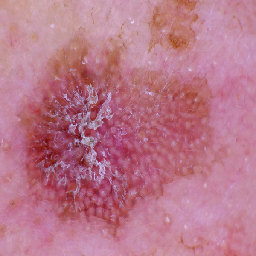

In [3]:
# Preview an image
array_to_img(train_images[0])

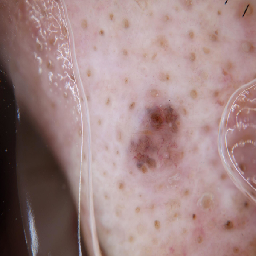

In [4]:
# Preview an image
array_to_img(test_images[0])

In [5]:
train_labels.shape

(2239, 9)

In [6]:
test_labels.shape

(118, 9)

In [7]:
test_images.shape

(118, 256, 256, 3)

In [8]:
train_images.shape

(2239, 256, 256, 3)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [11]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
sums=dataframe.sum(axis=0)

In [13]:
sums=pd.DataFrame(sums)

In [14]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [15]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [16]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


In [17]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [19]:
import keras

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [37]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
print(train_img.shape)
print(test_img.shape)

(2239, 196608)
(118, 196608)


In [27]:
train_y = np.reshape(train_labels[:,0], (2239,1))
test_y = np.reshape(test_labels[:,0], (118,1))

In [48]:
X=train_img
y=train_y

In [49]:
model = Sequential()

In [58]:
model.add(layers.Flatten())
model.add(Dense(24, activation='relu', input_shape=(196608,)))
model.add(Dense(12, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [61]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model.fit(X, y, epochs=50, batch_size=10)

Epoch 1/50
224/224 [==============================] - 14s 58ms/step - loss: 0.9865 - accuracy: 0.8874
Epoch 2/50
224/224 [==============================] - 11s 51ms/step - loss: 0.2213 - accuracy: 0.9491
Epoch 3/50
224/224 [==============================] - 11s 51ms/step - loss: 0.2034 - accuracy: 0.9491
Epoch 4/50
224/224 [==============================] - 12s 52ms/step - loss: 0.2027 - accuracy: 0.9491
Epoch 5/50
224/224 [==============================] - 12s 52ms/step - loss: 0.2026 - accuracy: 0.9491
Epoch 6/50
224/224 [==============================] - 12s 51ms/step - loss: 0.2029 - accuracy: 0.9491
Epoch 7/50
224/224 [==============================] - 11s 51ms/step - loss: 0.2023 - accuracy: 0.9491
Epoch 8/50
224/224 [==============================] - 12s 52ms/step - loss: 0.2025 - accuracy: 0.9491
Epoch 9/50
224/224 [==============================] - 12s 52ms/step - loss: 0.2024 - accuracy: 0.9491
Epoch 10/50
224/224 [==============================] - 12s 53ms/step - loss: 0.202